In [1]:
import numpy as np
import datetime
import netCDF4
import gsw
#-------------------------------------------------------------------------|
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cmocean
import cmocean.cm as cmo
#-------------------------------------------------------------------------|
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from scipy.io import loadmat
import xarray as xr
import math
import h5py
import pandas as pd
import re
from pathlib import Path
import os
import numpy.ma as ma
###############################
from pyresample import kd_tree, geometry, utils
from pyresample.geometry import GridDefinition
import pyproj as pyproj
from  pyproj import transform
from pyproj import Proj
# may make plotting faster
pyproj.set_use_global_context()
###############################
import sys
sys.path.append(r'/Users/houndegno/Documents/JupyterNoteBook/Prog/odi')
import odi
#-------------------------------------------------------------------------|
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Functions for detection ice advance/formation and ice retreat day

In [3]:
def ice_retreat_form_day(ice_con_array,ice_stick):
    #--------------------------------------------------------------
    ice_freez_days = list([])
    ice_leave_days = list([])
    #--------------------------------------------------------------
    for i in np.arange(ice_fraction.size-5):
        iteralength = np.arange(i+1,i+5+1,1)
        icecheck    = np.ndarray(shape = (5), dtype = float)*0
        iceretreat  = np.ndarray(shape = (5), dtype = float)*0
        for j in np.arange(iteralength.size):
            if (ice_fraction[iteralength[j]])>ice_stick:
                icecheck[j]   = 1
            else:
                iceretreat[j] = 1
        if sum(icecheck)== 5:
            ice_freez_days.append(i)
        if sum(iceretreat)== 5:
            ice_leave_days.append(i)
    #--------------------------------------------------------------
    ice_leave_index = min(np.array(ice_leave_days))
    ice_freez_index = min(np.array(ice_freez_days))
    return ice_leave_index,ice_freez_index 

In [4]:
def sea_ice_day(ice_conc,ice_stick,days_stick):
    """This function detect the sea ice formation/advance day. 
As input:
    => ice_conc = sea ice concentration array [express as "1" or "%"]
    => ice_stick = sea ice detection criteria [express as "1" or "%"]
    => days_stick = the number of days along which the the sea ice tchecking is made of
As output:
    => ice_day = is the index corresponding to the sea ice advance day according to the \n given sea ice concentration array.
---------------------------------------------------------------------------------------
Dr. Odilon Joël HOUNDEGNONTO ----------- contact: odilon.joel.houndegnonto@jpl.nasa.gov
                                                   or
                                          odilon.houndegnonto@gmail.com (personal mail)
                                                  Web: https://ojhoundegnonto.github.io         
NASA JPL, Decamber 13th, 2023 :----------------------------------- Pasadena (CA, U.S.A)
---------------------------------------------------------------------------------------
    """
    ice_day = np.array([])
    for i in np.arange(ice_conc.size-days_stick):
        ice_conc_sel_for_tcheck_at_day_i = ice_conc[np.arange(i,i+days_stick,1)]
        if np.where((ice_conc_sel_for_tcheck_at_day_i-ice_stick)>=0)[0].size == 5:
            ice_day = int(i)
            print("The sea ice formation/advance day is at %i index" % i)
            break
    return ice_day

In [5]:
def sea_ice_retreat_day(ice_conc,ice_stick,days_stick):
    """This function detect the sea ice formation/advance day. 
As input:
    => ice_conc = sea ice concentration array [express as "1" or "%"]
    => ice_stick = sea ice detection criteria [express as "1" or "%"]
    => days_stick = the number of days along which the the sea ice tchecking is made of
As output:
    => ice_day = is the index corresponding to the sea ice retreat day according to the \n given sea ice concentration array.
---------------------------------------------------------------------------------------
Dr. Odilon Joël HOUNDEGNONTO ----------- contact: odilon.joel.houndegnonto@jpl.nasa.gov
                                                   or
                                          odilon.houndegnonto@gmail.com (personal mail)
                                                  Web: https://ojhoundegnonto.github.io         
NASA JPL, December 13th, 2023 :----------------------------------- Pasadena (CA, U.S.A)
---------------------------------------------------------------------------------------
    """
    ice_day = np.array([])
    for i in np.arange(ice_conc.size-days_stick):
        ice_conc_sel_for_tcheck_at_day_i = ice_conc[np.arange(i,i+days_stick,1)]
        if np.where((ice_conc_sel_for_tcheck_at_day_i-ice_stick)<0)[0].size == 5:
            ice_day = int(i)
            print("The sea ice retreat day is at %i index" % i)
            break
    return ice_day

In [6]:
rep = "/Users/houndegno/Documents/MATLAB/Data/SASSIE_DATA/MITgcm_experiments/1D_OJH/1D_ocean_ice_column/Global_RUN/"
state = "/mnc_test_0002/state.0000000000.t001.nc"
sice = "/mnc_test_0002/sice.0000000000.t001.nc"
obsIceFrac = "/IceFrac_four_months.bin"

In [7]:
# profile selection
irun = 21
profID = "run_"+str(irun).zfill(3)

In [8]:
# model output
# T, S, Z and time from the model output
dstate = xr.open_dataset(rep+profID+state)
S = np.squeeze(dstate.S)
T = np.squeeze(dstate.Temp)
z = dstate.Z
t = dstate.T

In [9]:
# Ice_thikness and ice_concentration from the mode output
dsice = xr.open_dataset(rep+profID+sice)
ice_thik = np.squeeze(dsice.si_HEFF)
ice_fraction = np.squeeze(dsice.si_AREA)

In [10]:
# Observation Ice concentration from GES-DISC
IceFrac = np.fromfile(rep+profID+obsIceFrac, '>f4')

In [11]:
# forcing starting date
t0_forcing = np.datetime64('2022-09-01','ns')
# model starting date
t0_model = t[0]
# time stating index for obs data to match model outpu
obs_start_ind = int((t0_model - t0_forcing)/(1000000000*3600*24))

In [12]:
# model ice formation date with 15% criteria
# form the model
a = ice_retreat_form_day(ice_fraction,0.15)[1]
# form the observation
b = ice_retreat_form_day(IceFrac[obs_start_ind:],0.15)[1]
print("model ice date index",a,"\n obs ice date index",b)

model ice date index 35 
 obs ice date index 35


In [13]:
a2 = sea_ice_day(ice_conc=ice_fraction,ice_stick=0.15,days_stick=5)
a2

The sea ice formation/advance day is at 36 index


36

In [14]:
b2 = sea_ice_day(ice_conc=IceFrac[obs_start_ind:],ice_stick=0.15,days_stick=5)
b2

The sea ice formation/advance day is at 38 index


38

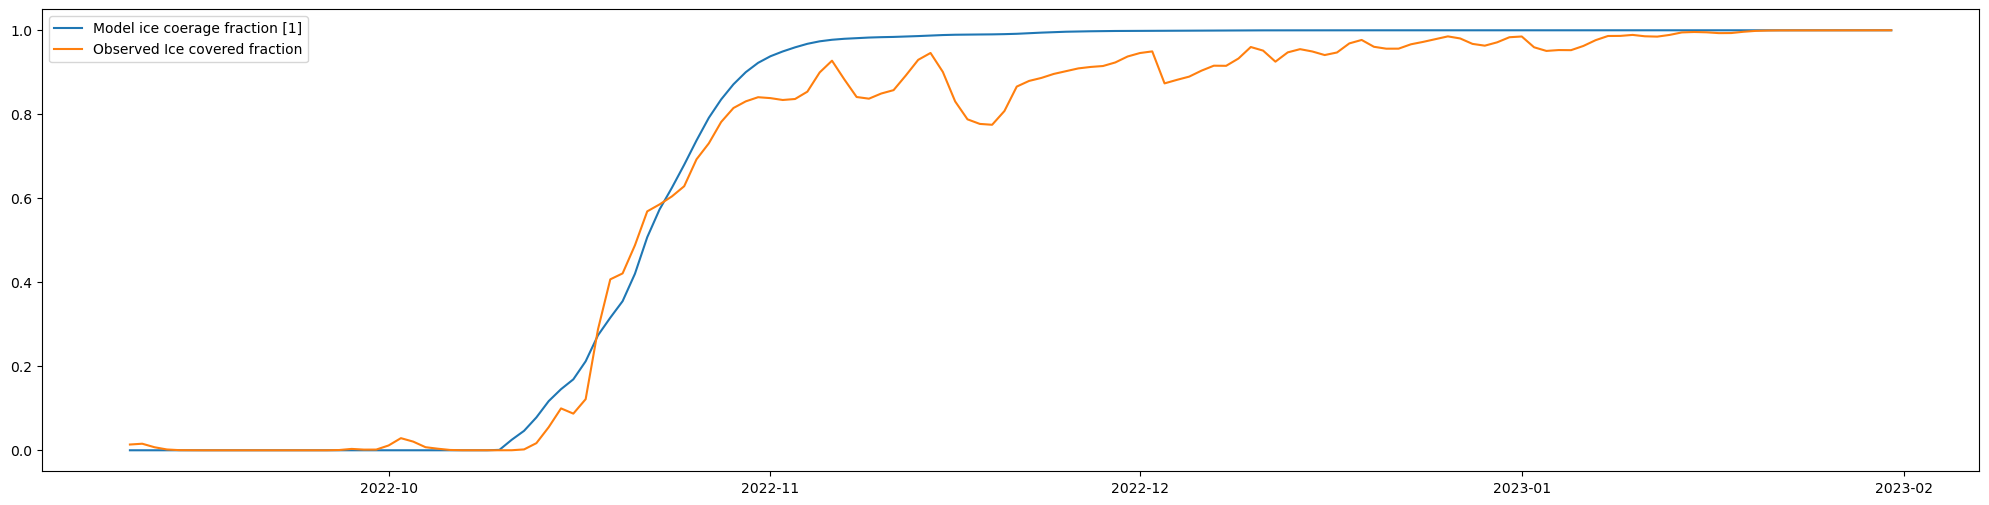

In [15]:
fig = plt.figure(figsize=[25,6], num=1);plt.clf();
plt.plot(t,ice_fraction,label='Model ice coerage fraction [1]')
plt.plot(t,IceFrac[obs_start_ind:],label='Observed Ice covered fraction')
plt.legend()

In [ ]:
#np.diff(IceFrac[obs_start_ind:])

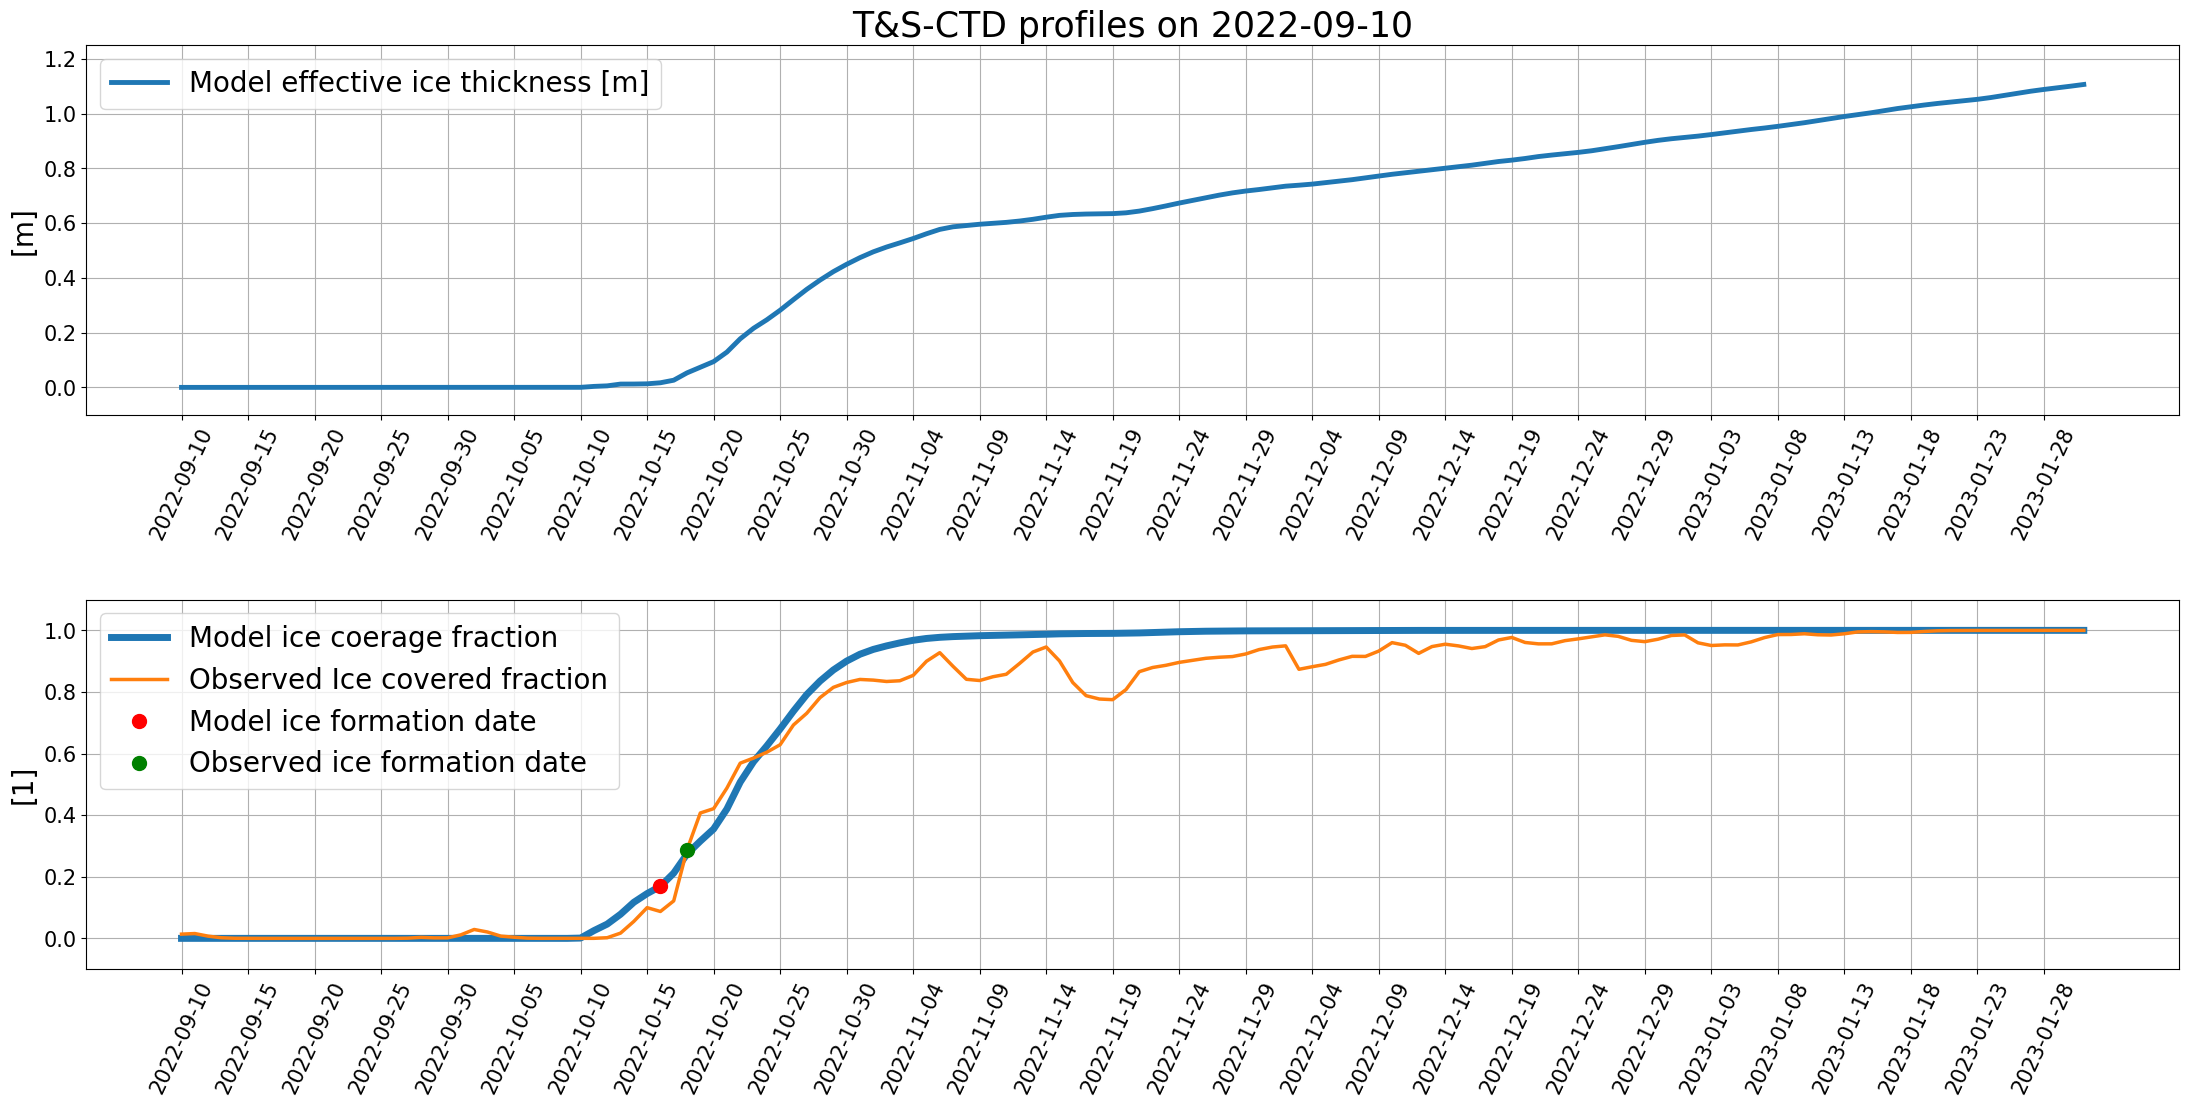

In [16]:
#-----------------------------------------------------------------------------------------------#
fig = plt.figure(figsize=[27,12], num=1);plt.clf();
fig.subplots_adjust(hspace=0.5)
plt.subplot(2,1,1)
plt.plot(t,np.squeeze(ice_thik),label='Model effective ice thickness [m]',linewidth=3.5)
#plt.plot(t[ti],IceFrac[ti],label='Observed Ice covered fraction')
plt.xticks(t[np.arange(0,t.size,5)],rotation=65,fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('[m]',fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.ylim(-.1,1.25)
plt.title("T&S-CTD profiles on "+str(np.array(t[0]))[slice(0,10,1)],fontsize=25)
#-----------------------------------------------------------------------------------------------#
plt.subplot(2,1,2)
plt.plot(t,np.squeeze(ice_fraction),label='Model ice coerage fraction',linewidth=5)
plt.plot(t,IceFrac[obs_start_ind:],label='Observed Ice covered fraction',linewidth=2.5)
## Model ice formation date
plt.plot(t[a2],ice_fraction[a2],'or',markersize=10,label='Model ice formation date')
## observed ice formation date
plt.plot(t[b2],IceFrac[obs_start_ind:][b2],'og',markersize=10,label='Observed ice formation date')
plt.xticks(t[np.arange(0,t.size,5)],rotation=65,fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(-0.1,1.1)
plt.grid()
plt.ylabel('[1]',fontsize=20)
plt.legend(fontsize=20)

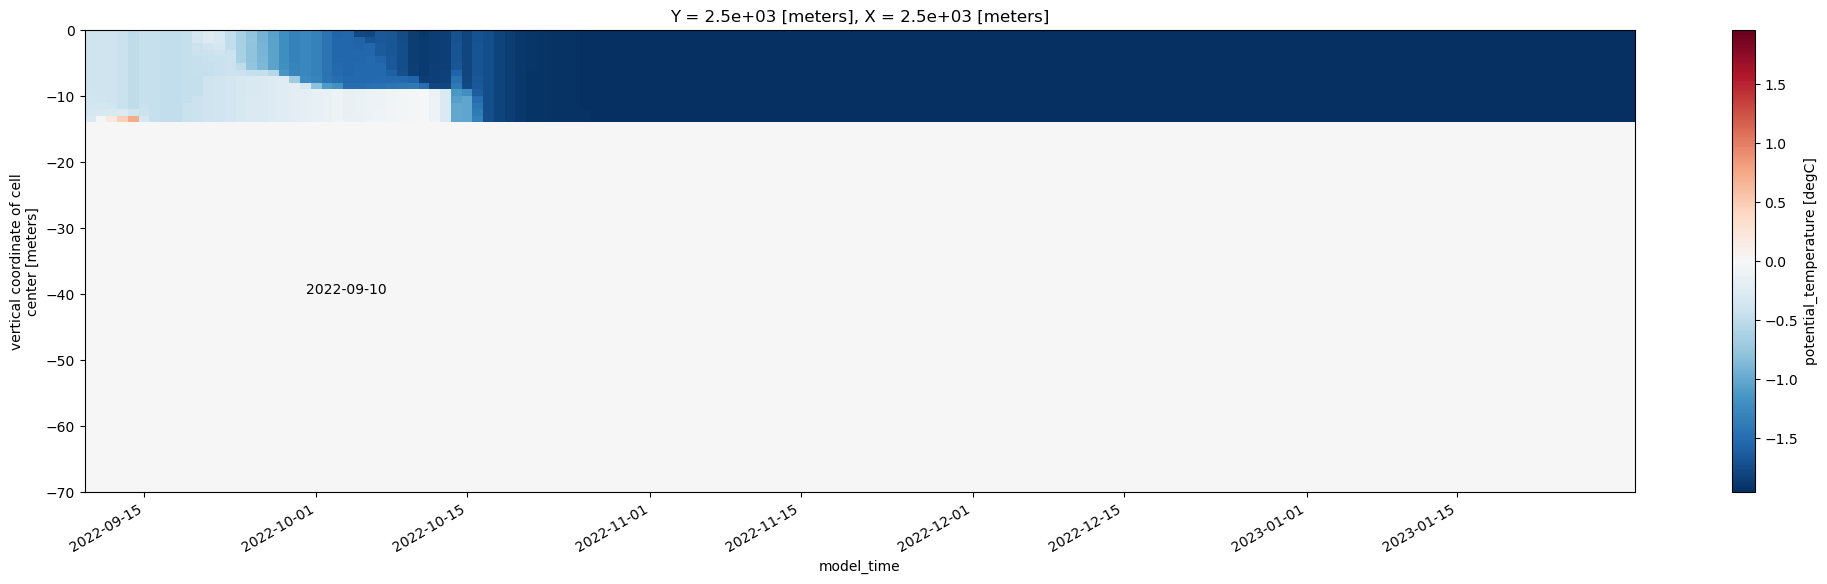

In [17]:
fig = plt.figure(figsize=[25,6], num=1);plt.clf();
T.T.plot()
zata = plt.text(t[20],-40,str(np.array(t[0]))[slice(0,10,1)])

for i in np.arange(250):
    plt.plot(np.fromfile(rep+"run_"+str(i+1).zfill(3)+obsIceFrac, '>f4'))

fig = plt.figure(figsize=[25,6], num=1);plt.clf();
for i in np.arange(250):
    plt.plot(np.squeeze(xr.open_dataset(rep+"run_"+str(i+1).zfill(3)+sice).si_AREA))

A = np.ones(250)
for i in np.arange(250):
    profID = "run_"+str(i+1).zfill(3)
    h = np.fromfile(rep+profID+'/bathy_1x1_1105m_testpool', '>f4')
    print(profID,"==>",h)
    A[i] = h

import netCDF4
from netCDF4 import Dataset

dataset = netCDF4.MFDataset(['1.nc','2.nc','3.nc','4.nc'])

ds = xr.open_mfdataset('nc_*.nc', combine = 'by_coord', concat_dim = 'time')

ds.to_netcdf('nc_combined.nc') # Export netcdf file

In [ ]:
sea_ice_day(ice_conc=ice_fraction,ice_stick=0.9,days_stick=10)

In [ ]:
help(sea_ice_retreat_day)

In [ ]:
sea_ice_retreat_day(ice_conc=ice_fraction,ice_stick=0.15,days_stick=5)